In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

## Loading the data

First of all, I will load the data from the `.csv` file into a pandas `dataframe`.

In [2]:
import pandas as pd 

data = pd.read_csv("dataset.csv", keep_default_na = False) 
# NA values are parsed as NaN by default, so we add keep_default_na = False to prevent this
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65,8450,Pave,NA,Reg,Lvl,AllPub,...,0,NA,NA,NA,0,2,2008,WD,Normal,208500
1,2,20,RL,80,9600,Pave,NA,Reg,Lvl,AllPub,...,0,NA,NA,NA,0,5,2007,WD,Normal,181500
2,3,60,RL,68,11250,Pave,NA,IR1,Lvl,AllPub,...,0,NA,NA,NA,0,9,2008,WD,Normal,223500
3,4,70,RL,60,9550,Pave,NA,IR1,Lvl,AllPub,...,0,NA,NA,NA,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84,14260,Pave,NA,IR1,Lvl,AllPub,...,0,NA,NA,NA,0,12,2008,WD,Normal,250000


## Plotting the features

To get a general feeling of the data, I'll plot `SalePrice` as a function of every feature:

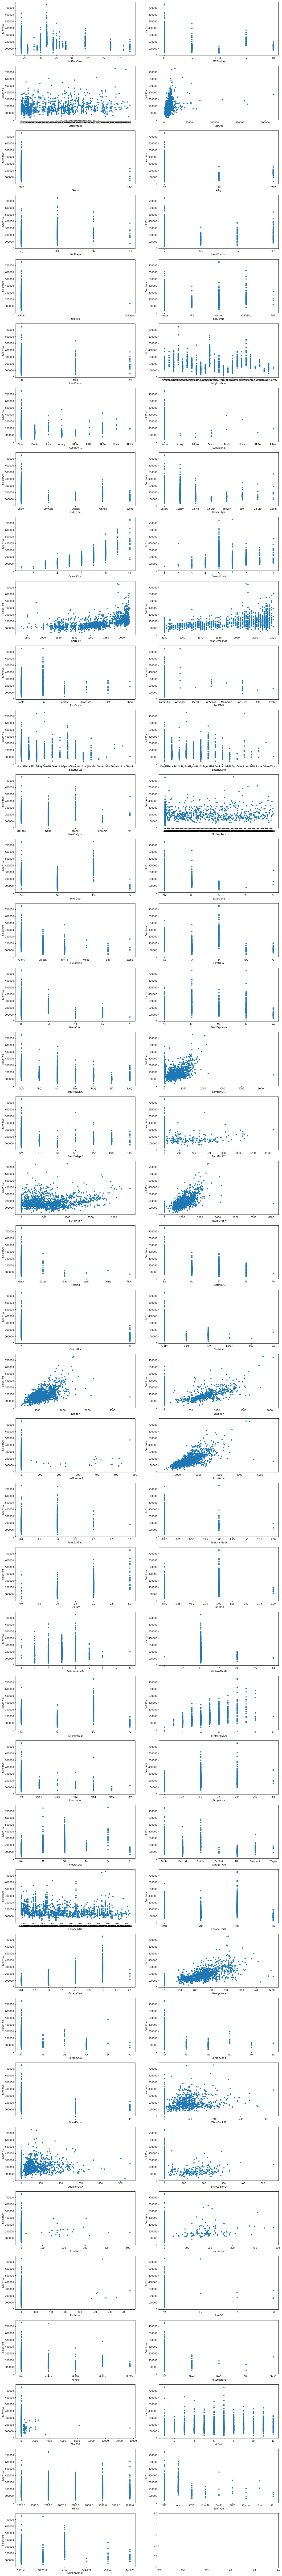

In [3]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows = (len(data.columns) - 2) // 2 + 1, 
                         ncols=2,
                        figsize=(20, 5*40))

i = 0
for column in data.columns[1:-1]:
    rownum = i // 2
    colnum = i % 2
    data.plot.scatter(ax = axes[rownum, colnum], x = column, y = "SalePrice")
    i += 1 

I've looked through the plots and identified the most promising variables for regression:
* `OverallQual`
* `YearBuilt`
* `TotalBsmtSF`
* `GrLivArea`.

Let's have a look at them:

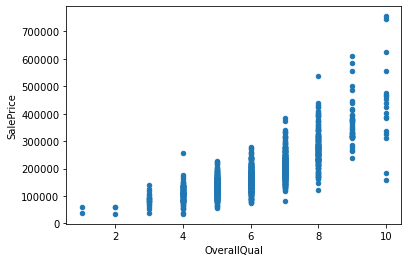

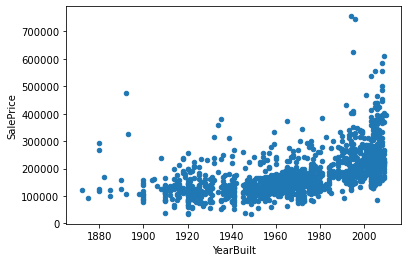

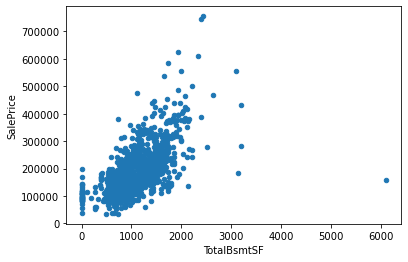

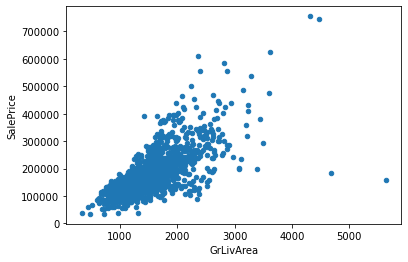

In [4]:
for feature in ["OverallQual", "YearBuilt", "TotalBsmtSF", "GrLivArea"]:
    data.plot.scatter(x = feature, y = "SalePrice")

## Feature selection via mutual information

But instead of selecting the features heuristically by means of visual inspection, I'm going to quantify the amount of information about the `SalePrice` that is contained in each of the features.
A suitable tool to that end is **mutual information**, which, unlike linear regressors, is able to reflect nonlinear dependencies. Since I don't really know if the best predictor is linear, I'll stick to this more general metric of predictive power of a feature.

An example of a potentially informative feature that doesn't show any clear linear relationship to `SalePrice` is `Neighborhood`:

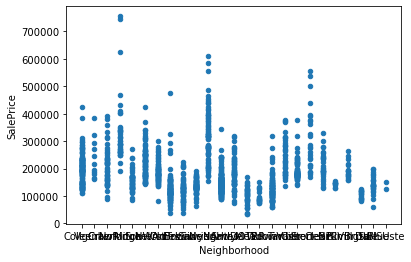

In [5]:
data.plot.scatter(x = "Neighborhood", y = "SalePrice")
pass

I'll use the scikit-learn library that has a method to estimate mutual information between a feature and a target continuous variable (`SalePrice` in our case) --- `mutual_info_regression`.

I have to take into account that some of the features in our dataset aren't continuous. Mutual information is calculated differently for discrete and continuous random variables. Moreover, discrete random variables in our dataset have string values, which we need to replace with distinct numerical values for the method to work.

In [6]:
import numpy as np
from sklearn.feature_selection import mutual_info_regression

df = pd.read_csv("dataset.csv")

continuous_features = ['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 
'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF','2ndFlrSF', 'LowQualFinSF',
'GrLivArea','TotRmsAbvGrd', 'Fireplaces', 'GarageCars',
'GarageArea', 'WoodDeckSF', 'OpenPorchSF', '3SsnPorch', 'ScreenPorch',
'PoolArea', 'MiscVal']
y = df['SalePrice']
mi_array = []
for column in df.columns[1:-1]:
    if column in continuous_features:
        numeric_column = df[column].fillna(0)
        x = np.asarray(numeric_column).reshape(-1,1)
        mi = mutual_info_regression(x, y) # continuous features assumed by default

    else:
        dict_values = {}
        numeric_column = df[column].fillna(0)
        i = 0
        for element in numeric_column:
            if element not in dict_values:
                dict_values[element] = i
                i += 1

        new_values_array = np.vectorize(lambda x: dict_values[x])(numeric_column)

        mi = mutual_info_regression(new_values_array.reshape(-1,1), y, discrete_features=True)

    mi_array.append((mi[0], column))


mi_array.sort(key=lambda tup: tup[0], reverse=True)
for mi, column in mi_array:
    print(mi, column)

0.5746451483073214 OverallQual
0.5239504077717925 Neighborhood
0.407261762006196 YearBuilt
0.3768676104584636 GrLivArea
0.35032147603435915 GarageCars
0.344942555661893 GarageYrBlt
0.3386517119809449 BsmtQual
0.32946972314707623 ExterQual
0.32389387266368863 KitchenQual
0.28133512323655685 GarageArea
0.28010216305445645 MSSubClass
0.27673987799833366 YearRemodAdd
0.26352585533717243 FullBath
0.25896491668173893 GarageFinish
0.2584753877367043 TotalBsmtSF
0.23625525906065636 1stFlrSF
0.2097337326455957 GarageType
0.20894486858819272 LotFrontage
0.20844656263700956 FireplaceQu
0.20213029483807454 Foundation
0.18012099155158046 TotRmsAbvGrd
0.16332565625515327 HeatingQC
0.16043272038642975 Exterior2nd
0.1568571328078987 Fireplaces
0.15227569908994054 BsmtFinType1
0.13554666144465566 Exterior1st
0.13463657246839023 BsmtFinSF1
0.12900712335175601 MSZoning
0.11842822719253254 OverallCond
0.10533283654573711 MasVnrType
0.10344888568979593 2ndFlrSF
0.09376942723241788 LotArea
0.088130226490239

## Conclusion

Based on the above estimation of mutual information, I conclude that **the single best feature that tells us the most about `SalePrice` is `OverallQual`.**

I must remark that mutual information doesn't give us any explicit way to perform the regression. That question, however, falls outside of the scope of initial contribution and will be addressed later.

Let's have a look at the top-three features in terms of their potential predictive power:

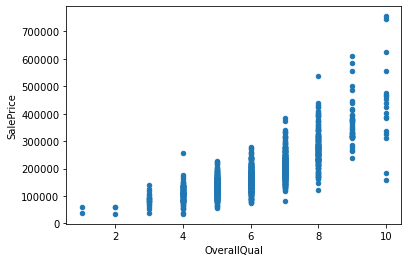

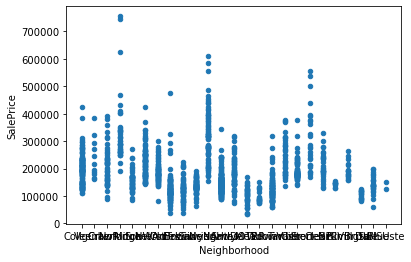

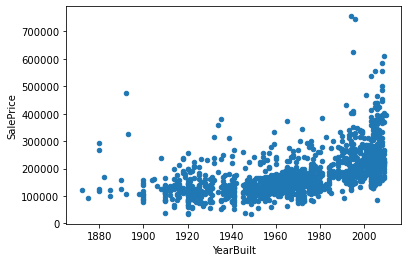

In [7]:
top_three_features = map(lambda x: x[1], mi_array[0:3])
for feature in top_three_features:
    data.plot.scatter(x = feature, y = "SalePrice")

# 2nd contribution task

Previously I devided features in the dataset into two categories: continuous and discrete. I based my assumptions on the explanation given to the columns: e.g. "LotArea" - Lot size in *square feet*, therefore continuous, "Street" - *Type* of road, Gravel/Paved, therefore discrete.

I should consider these types of features when choosing the regression model.
**Polynomial interpolation** would work well for continuous features, because it's continuous in nature and allows for non-linear dependencies. Furthermore, we have rather big gaps in the data, so it seems logical to use interpolation to guess the values in between sparse data points.

### Building the model for continuous features

As I concluded previously, the top-three features that have the biggest mutual information score with `SalePrice` are `OverallQual`, `Neighborhood` and `YearBuilt`. I've categorized them all into discrete features, so I conclude that I should focus on them first.

Still I'd like to check what can be modelled on continuous features.
Looking through the plots I can say that it's quite hard to figure out a clear dependency between any of the continuous features and `SalePrice`: I mostly see vast 'cloud' forms, frequently with spaced out outliers.

I'm going to split the data into train-test sets and plot it, and look at the coefficient of determination to check my assumptions:

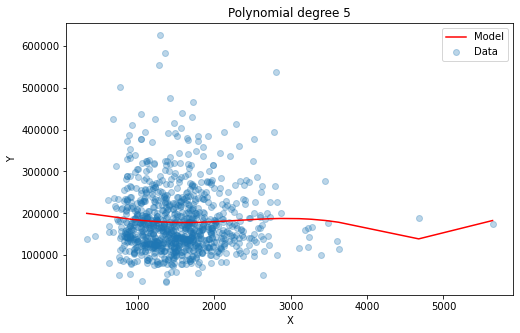

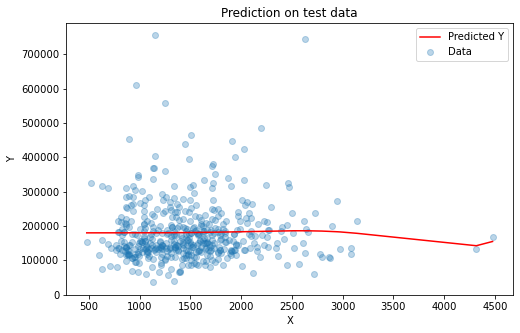

R2 score:  0.0005277272438237723


In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline, make_pipeline

from sklearn.model_selection import train_test_split

df = pd.read_csv("dataset.csv")
y = df['SalePrice']
x = np.asarray(df['GrLivArea'])

#SPLITTING into train-test sets:
X_train, X_test, y_train, y_test = train_test_split(
    x, y, test_size=0.33, random_state=42)

def plot_polynomial_regression(attribute_x, target_y, degree=5):
    x = attribute_x
    y = target_y
    polynomial_model = make_pipeline(PolynomialFeatures(degree = degree),LinearRegression())
    x_sorted = np.sort(x)
    polynomial_model.fit(x_sorted.reshape(-1,1),y)
    plt.figure(figsize = (8,5))
    plt.scatter(x_sorted,y, alpha = .3, label = 'Data')
    
    plt.plot(x_sorted,polynomial_model.predict(x_sorted.reshape(-1,1)), color = 'red', label = 'Model')
    plt.title('Polynomial degree 5')
    plt.xlabel('X'), plt.ylabel('Y')
    plt.legend(), plt.show()

plot_polynomial_regression(X_train, y_train)

# Prediction and evaluation

polynomial_model = make_pipeline(PolynomialFeatures(degree = 10),LinearRegression())
x_test_sorted = np.sort(X_test)
polynomial_model.fit(np.sort(X_train).reshape(-1,1),y_train) #training input samples to .fit
predicted_y = polynomial_model.predict(x_test_sorted.reshape(-1,1))

    
plt.figure(figsize = (8,5))
plt.scatter(x_test_sorted,y_test, alpha = .3, label = 'Data')

plt.plot(x_test_sorted, predicted_y, color = 'red', label = 'Predicted Y')
plt.title('Prediction on test data')
plt.xlabel('X'), plt.ylabel('Y')
plt.legend(), plt.show()

prediction_score = polynomial_model.score(np.asarray(X_test).reshape(-1, 1), np.asarray(y_test).reshape(-1, 1))
print("R2 score: ", prediction_score)

I see that the R2 score is very very *low*, so I'll leave the continuous features for now and move on to the discrete ones.

## Building the model for discrete features

I'll split the data into train and test sets and look at the model we get with decision tree regressor for top-4 features.

'OverallQual', 'YearBuilt', 'GarageCars' - are Numerical discrete type of covariates.
'Neighborhood' - is a Categorical nominal, so I shall translate the string values to different numerical discrete values before training. 

I assign these numerical values randomly, because I don't know what neighborhood is considered "good" or "bad". I assume that the "good" one will increase the price and the "bad" one will lower it. This correlation isn't going to affect the performance of the model because if it exists, it will be derived from the training set.

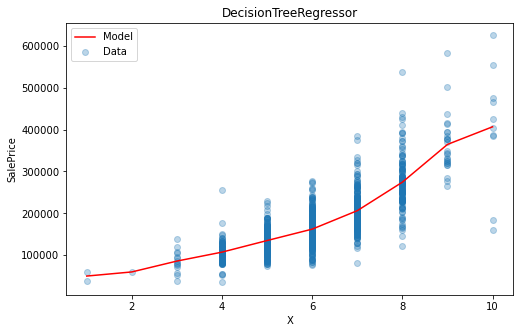

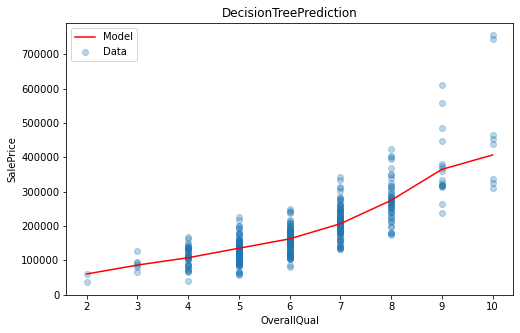

Decision Tree R2 score:  0.7012544563766507


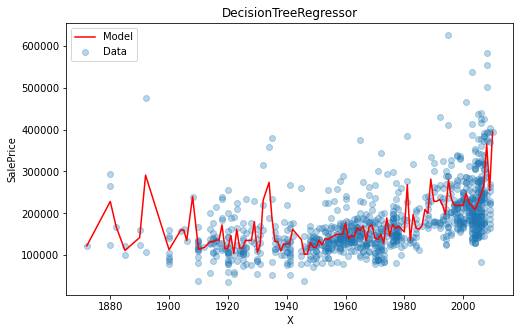

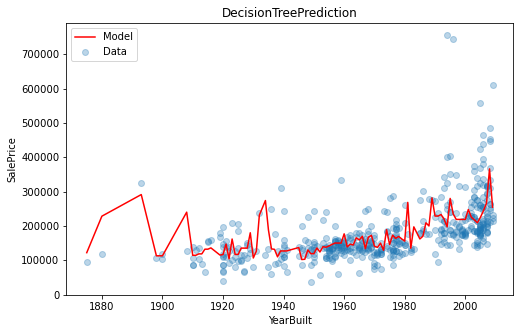

Decision Tree R2 score:  0.34000446805080176


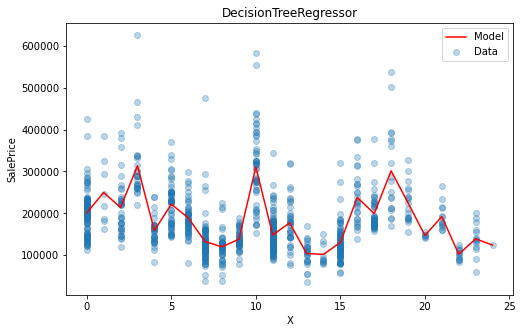

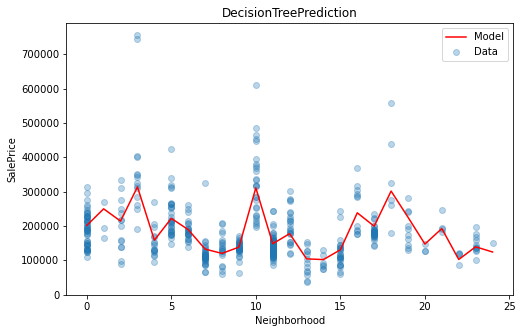

Decision Tree R2 score:  0.5453257507030342


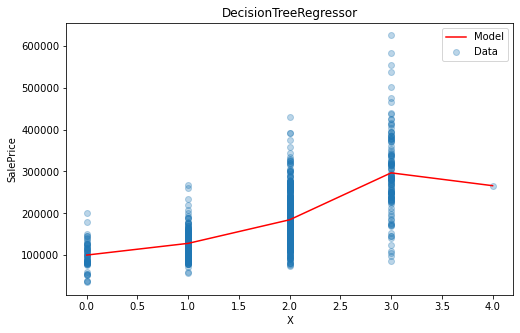

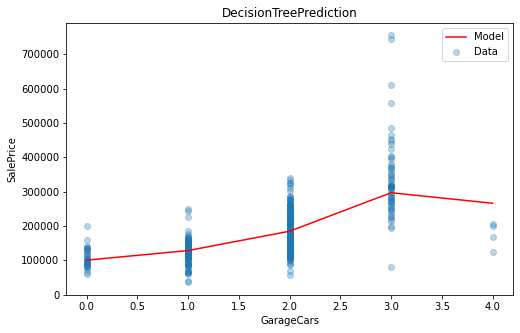

Decision Tree R2 score:  0.5107784814715617


In [9]:
from sklearn.tree import DecisionTreeRegressor

def plot_decision_tree_regressor(attribute_x, target_y, x_label='X', y_label='Y', maximum_depth=10):
    x = attribute_x
    y = target_y
    model = DecisionTreeRegressor(max_depth = maximum_depth)
    model.fit(x.reshape(-1,1),y)
    plt.figure(figsize = (8,5))
    x_sorted = np.sort(x)
    plt.scatter(x,y, alpha = .3, label = 'Data')
    plt.plot(x_sorted,model.predict(x_sorted.reshape(-1,1)), color = 'red', label = 'Model')
    plt.title('DecisionTreeRegressor')
    plt.xlabel(x_label), plt.ylabel(y_label)
    plt.legend(), plt.show()

from sklearn.model_selection import train_test_split
df = pd.read_csv("dataset.csv")


for column in ['OverallQual', 'YearBuilt', 'Neighborhood', 'GarageCars']:
    y = df['SalePrice']
    if column in ['Neighborhood']:
        dict_values = {}
        numeric_column = df[column].fillna(0)
        i = 0
        for element in numeric_column:
            if element not in dict_values:
                dict_values[element] = i
                i += 1

        new_values_array = np.vectorize(lambda x: dict_values[x])(numeric_column)
        
        x = np.asarray(new_values_array)
    else:
        x = np.asarray(df[column])

    X_train, X_test, y_train, y_test = train_test_split(
        x, y, test_size=0.33, random_state=42)

    plot_decision_tree_regressor(X_train, y_train, x_label='X', y_label='SalePrice')

    d_tree_model = DecisionTreeRegressor(max_depth = 10)
    d_tree_model.fit(X_train.reshape(-1,1),y_train)
    predicted_y = d_tree_model.predict(np.sort(X_test).reshape(-1,1))

    plt.figure(figsize = (8,5))
    plt.scatter(X_test,y_test, alpha = .3, label = 'Data')
    plt.plot(np.sort(X_test).reshape(-1,1), predicted_y, color = 'red', label = 'Model')
    plt.title('DecisionTreePrediction')
    plt.xlabel(column), plt.ylabel('SalePrice')
    plt.legend(), plt.show()

    dt_prediction_score = d_tree_model.score(np.asarray(X_test).reshape(-1, 1), np.asarray(y_test).reshape(-1, 1))
    print("Decision Tree R2 score: ", dt_prediction_score)

Here I see the best R2 score being for the `OverallQual`: 0.70125, which is rather substantial, 
moderate 0.54532 for `Neighborhood` and 0.51077 for `GarageCars`.


I'll build a model on **combination of these features** and see if I can get even better coefficient of determintaion.

In [10]:
x = (df[['OverallQual', 'YearBuilt']]).values
y = df['SalePrice'].values

X_train, X_test, y_train, y_test = train_test_split(
        x, y, test_size=0.33, random_state=42)

dt = DecisionTreeRegressor(max_depth = 10)
dt.fit(X_train, y_train)
dt_pred_train = dt.predict(X_train)

print('Training Set Evaluation R2-Score',dt.score(X_test, y_test))

Training Set Evaluation R2-Score 0.7015490695982747


I get a bit better results if I add `YearBuilt` to `OverallQual`: 0.70154 (compared to 0.70125).


Any other combination of two or more top features, unfortunately, doesn't seem to improve the R2.

In [11]:
df['Neighborhood']=df['Neighborhood'].map({'Blmngtn':1, 'Blueste':2, 'BrDale':3, 'BrkSide':4, 'ClearCr':5,
'CollgCr':6, 'Crawfor':7, 'Edwards':8, 'Gilbert':9, 'IDOTRR':10,'MeadowV':11, 'Mitchel':12,
'Names':13, 'NoRidge':14, 'NPkVill':15, 'NridgHt':16, 'NWAmes':17, 'OldTown':18, 'SWISU':19,
'Sawyer':20, 'SawyerW':21, 'Somerst':22, 'StoneBr':23, 'Timber':24, 'Veenker':25}) # Categorical nominal data
df['KitchenQual']=df['KitchenQual'].map({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}) # Categorical ordinal data

df['KitchenQual']=df['KitchenQual'].fillna(0)
df['Neighborhood']=df['Neighborhood'].fillna(0)
df['GarageYrBlt']=df['GarageYrBlt'].fillna(0)


x = (df[['OverallQual', 'GarageYrBlt', 'YearBuilt', 'Neighborhood', 'KitchenQual']]).values
y = df['SalePrice'].values

X_train, X_test, y_train, y_test = train_test_split(
        x, y, test_size=0.33, random_state=42)

dt = DecisionTreeRegressor(max_depth = 10)
dt.fit(X_train, y_train)
dt_pred_train = dt.predict(X_train)

print('Training Set Evaluation R2-Score',dt.score(X_test, y_test))

Training Set Evaluation R2-Score 0.5732266529306582


I'll check out the **Random Forest Regressor**'s performance. I know it performs well on large datasets, and this one is rather small... It still might generalize the features in a better way, plus I don't have to interpret the model, so I can give it a go.

In [12]:
from sklearn.ensemble import RandomForestRegressor

x = (df[['OverallQual', 'YearBuilt', 'Neighborhood', 'GarageYrBlt', 'KitchenQual']]).values
y = df['SalePrice'].values

X_train, X_test, y_train, y_test = train_test_split(
        x, y, test_size=0.33, random_state=42)

rf = RandomForestRegressor(max_depth = 10)
rf.fit(X_train, y_train)

print('Testing Set Evaluation R2-Score',rf.score(X_test, y_test))

Testing Set Evaluation R2-Score 0.7514221838395146


The `Random Forest Regressor` chooses the features *randomly*, hence the coefficient of determination is varying, but it still performs better than the Decision Forest Regressor: **0.75412**, a rather good prediction.

Let's look if it overfits or underfits the data:


In [13]:
from sklearn.ensemble import RandomForestRegressor

x = (df[['OverallQual', 'YearBuilt', 'Neighborhood', 'GarageYrBlt', 'KitchenQual']]).values
y = df['SalePrice'].values

X_train, X_test, y_train, y_test = train_test_split(
        x, y, test_size=0.33, random_state=42)

rf = RandomForestRegressor(max_depth = 10)
rf.fit(X_train, y_train)
print('Training Set Evaluation R2-Score',rf.score(X_train, y_train))
print('Testing Set Evaluation R2-Score',rf.score(X_test, y_test))

Training Set Evaluation R2-Score 0.9120858423046345
Testing Set Evaluation R2-Score 0.7444586318791879


## Conclusion:

My model of choice is `Random Forest Regressor` performed on the discrete features `OverallQual`, `YearBuilt`, `Neighborhood`, `GarageYrBlt`, `KitchenQual`, that showed the highest rate of mutual information with target attribute `SalePrice`. The model built on their combination results in the highest R2 score, which is the best among the models I've tried.

It slightly **overfits** the data in the sense that it performs considerably better on the training set than on the testing set
(Training Set : 0.82041, Testing Set : 0.72073). However, the model generalizes quite well to the testing set as well. I believe that if we had more data to train on, we could improve the predictions.